In [1]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'theme3_tss',
        root = '..'
    )

In [2]:
import numpy as np
import pandas as pd
import pyranges as pr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [3]:
df_abundance = pd.read_csv(snakemake.input['abundance'], sep='\t').set_index('annot_transcript_id')
samples = df_abundance.columns[11:]

transcript_tpm_filter = 1

tpm = df_abundance[samples].div(df_abundance[samples].sum(axis=0) / 1_000_000, axis=1)
df_abundance = df_abundance[(tpm >= transcript_tpm_filter).any(axis=1)]

expressed_genes = set(df_abundance['annot_gene_id'])
expressed_transcripts = set(df_abundance.index)

In [4]:
_gr_gtf = pr.read_gtf(snakemake.input['gtf'])
protein_coding_genes = set(_gr_gtf[_gr_gtf.gene_type == 'protein_coding'].gene_id)

In [10]:
gr_gtf = pr.read_gtf(snakemake.input['gtf_talon_corrected'])

In [11]:
gr_gtf = gr_gtf[gr_gtf.gene_id.isin(protein_coding_genes & expressed_genes)]
gr_gtf = gr_gtf[gr_gtf.transcript_id.isin(expressed_transcripts)]

## Transcript Length

In [12]:
gr_transcripts = gr_gtf[gr_gtf.Feature == 'transcript']

In [82]:
gr_exons = gr_gtf[gr_gtf.Feature == 'exon']

In [50]:
transcript_lengths = pd.Series(gr_transcripts.lengths().tolist(), 
                               index=gr_transcripts.transcript_id.tolist())

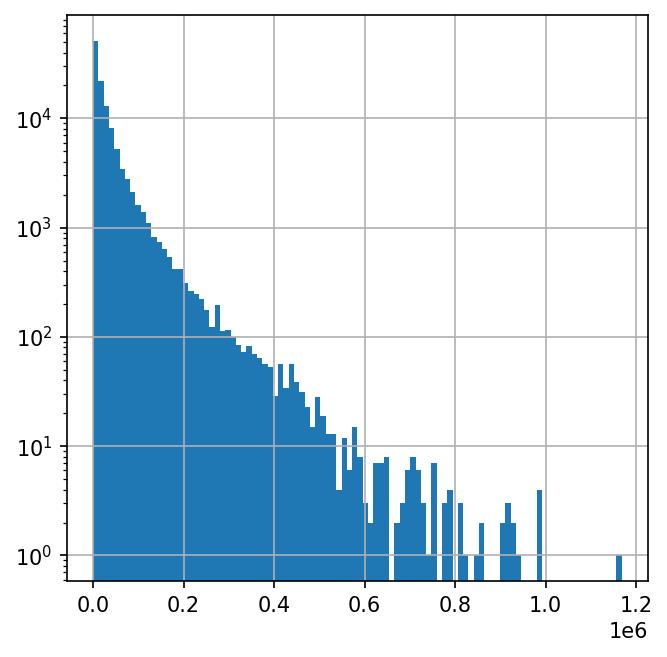

In [81]:
plt.figure(figsize=(5, 5), dpi=150)
transcript_lengths.hist(bins=100)
plt.yscale('log')

In [270]:
df = tpm.loc[gr_transcripts.transcript_id].reset_index() \
    .melt(id_vars='annot_transcript_id', var_name='sample', value_name='TPM') \
    .set_index('annot_transcript_id')

In [271]:
tpm_dif = (tpm[tpm > 0].max(axis=1) - tpm[tpm > 0].min(axis=1))

df = df[df.index.isin(tpm_dif[tpm_dif > 10].index)]

In [272]:
df = df[df['TPM'] > 1]

In [273]:
df['total_length'] = transcript_lengths

In [274]:
df_exon_len = pd.DataFrame({
    'exon_length': gr_exons.lengths().tolist(),
    'transcript_id': gr_exons.transcript_id.tolist()    
})
df['num_exon'] = df_exon_len.groupby('transcript_id').size()
df['exon_length'] = df_exon_len.groupby('transcript_id').sum()['exon_length']

In [275]:
from scipy.stats import pearsonr, spearmanr

spearmanr(np.log(df['TPM']), np.log(df['total_length']))

SpearmanrResult(correlation=0.03325856321462385, pvalue=0.0)

In [ ]:
plt.figure(figsize=(5, 5), dpi=150)

sns.scatterplot(y=np.log10(df['TPM']), x=np.log10(df['total_length']), s=0.1) # kind=""

In [277]:
from scipy.stats import pearsonr, spearmanr

spearmanr(np.log(df['TPM']), df['exon_length'])

SpearmanrResult(correlation=-0.037979657333372635, pvalue=0.0)

<AxesSubplot:xlabel='exon_length', ylabel='TPM'>

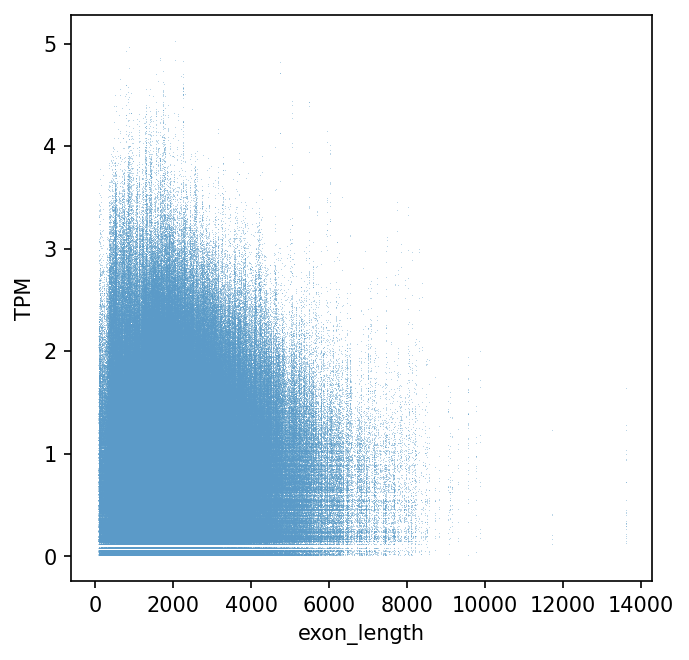

In [278]:
plt.figure(figsize=(5, 5), dpi=150)

sns.scatterplot(y=np.log10(df['TPM']), x=df['exon_length'], s=0.1)

In [279]:
df['intron_length'] = df['total_length'] - df['exon_length']

In [280]:
from scipy.stats import pearsonr, spearmanr

pearsonr(np.log(df['TPM']), df['exon_length'])

(-0.05869004348598626, 0.0)

In [281]:
from scipy.stats import pearsonr, spearmanr

spearmanr(df['num_exon'], np.log10(df['TPM']))

SpearmanrResult(correlation=0.02275438674740602, pvalue=2.8577511877426062e-245)

<AxesSubplot:xlabel='num_exon', ylabel='TPM'>

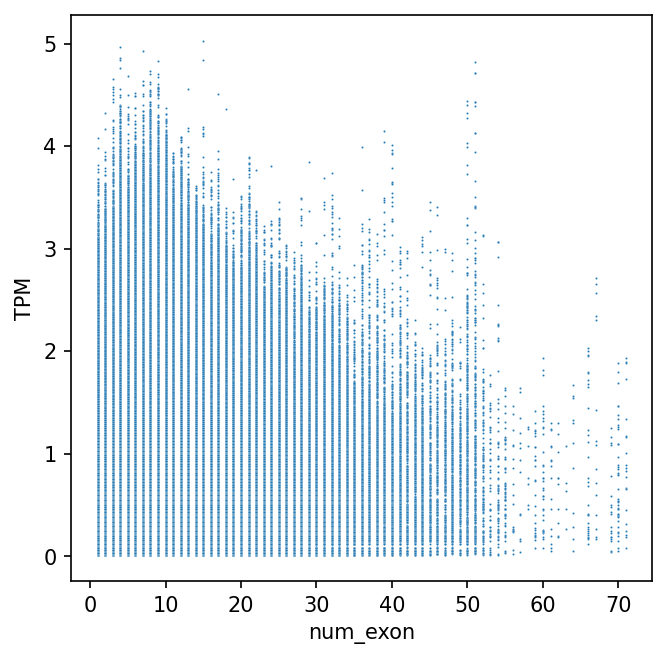

In [282]:
plt.figure(figsize=(5, 5), dpi=150)

sns.scatterplot(y=np.log10(df['TPM']), x=df['num_exon'], s=1)

In [284]:
df_exon_first = pd.DataFrame({
    'first_exon_length': gr_exons[gr_exons.exon_number == '1'].lengths(),
    'transcript_id': gr_exons[gr_exons.exon_number == '1'].transcript_id.tolist()    
})
df['first_exon_length'] = df_exon_first.set_index('transcript_id')['first_exon_length']

In [285]:
from scipy.stats import pearsonr, spearmanr

pearsonr(df['TPM'], df['first_exon_length'])

(-0.016143295755533985, 1.8696370026328377e-124)

<AxesSubplot:xlabel='first_exon_length', ylabel='TPM'>

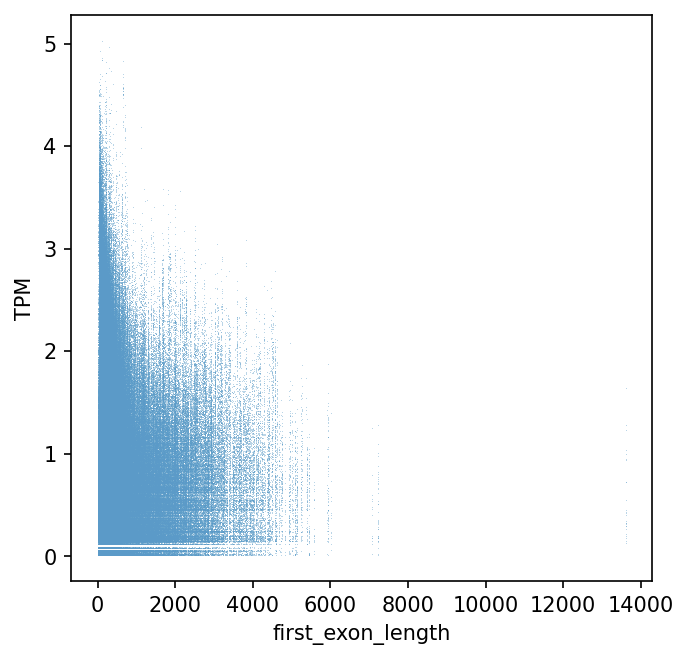

In [286]:
plt.figure(figsize=(5, 5), dpi=150)

sns.scatterplot(y=np.log10(df['TPM']), x=df['first_exon_length'], s=0.1)

<AxesSubplot:xlabel='first_exon_length', ylabel='TPM'>

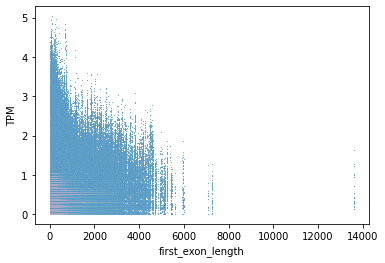

In [338]:
sns.scatterplot(y=np.log10(df['TPM']), x=df['first_exon_length'], s=1)

In [287]:
_df_last_exon = gr_exons.df[['transcript_id', 'exon_number']].groupby('transcript_id').max()
_df_last_exon = (gr_exons.df.set_index(['transcript_id', 'exon_number']).loc[
    _df_last_exon.set_index('exon_number', append=True).index])
gr_last_exons = pr.PyRanges(_df_last_exon.reset_index())

df_exon_last = pd.DataFrame({
    'last_exon_length': gr_last_exons.lengths(),
    'transcript_id': gr_last_exons.transcript_id.tolist()    
})
df['last_exon_length'] = df_exon_last.set_index('transcript_id')['last_exon_length']

In [316]:
from scipy.stats import pearsonr, spearmanr

spearmanr(np.log10(df['TPM']), df['last_exon_length'])

SpearmanrResult(correlation=-0.02018653196350899, pvalue=1.7888701737432965e-193)

<AxesSubplot:xlabel='last_exon_length', ylabel='TPM'>

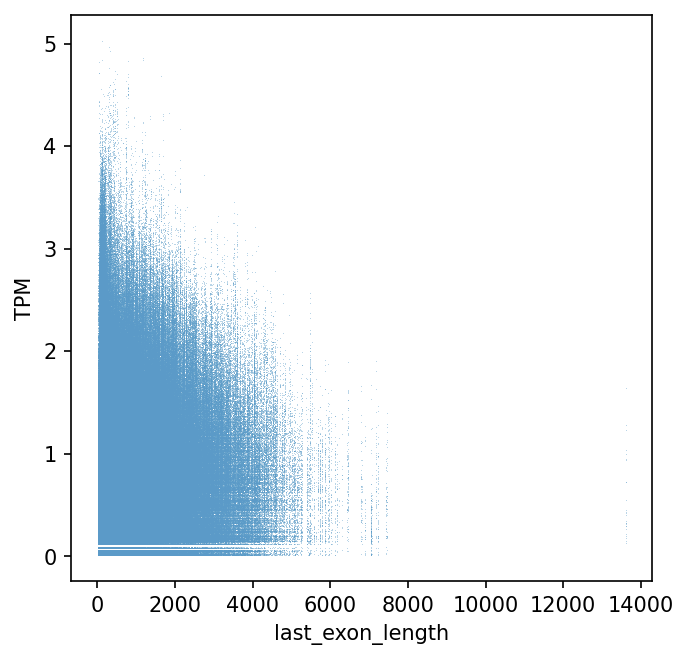

In [317]:
plt.figure(figsize=(5, 5), dpi=150)

sns.scatterplot(y=np.log10(df['TPM']), x=df['last_exon_length'], s=0.1)

In [308]:
from sklearn.linear_model import LinearRegression

model =  LinearRegression().fit(df[df.columns[2:]].values, df['TPM'].values)

In [318]:
tpm_pred = model.predict(df[df.columns[2:]].values)

spearmanr(df['TPM'].values, tpm_pred)

SpearmanrResult(correlation=0.047170452529042374, pvalue=0.0)

<AxesSubplot:ylabel='TPM'>

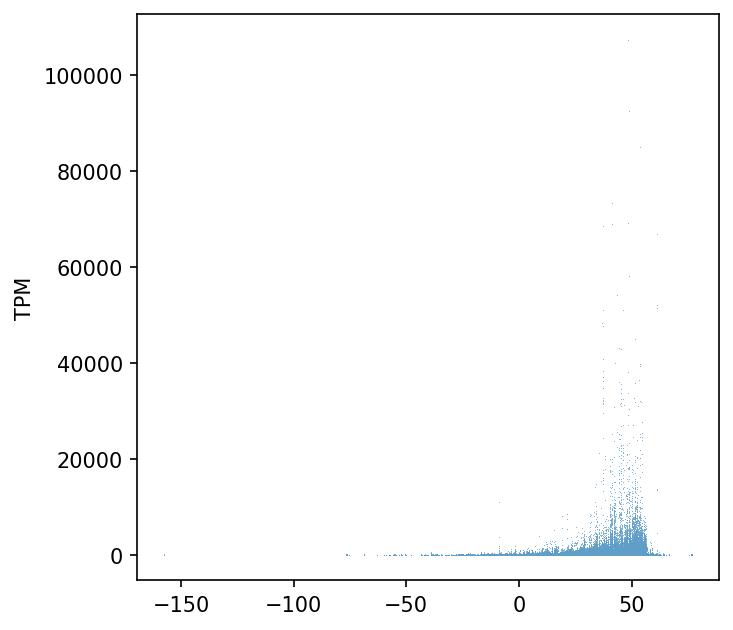

In [336]:
plt.figure(figsize=(5, 5), dpi=150)

sns.scatterplot(y=df['TPM'], x=tpm_pred, s=0.2)